We setup with all the required packages and load the data set. 

In [82]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
#tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 20
pd.options.display.float_format = '{:.1f}'.format

df = pd.read_csv("diabetes.csv", sep=",")

df = df.reindex(
    np.random.permutation(df.index))

We will randomize the data to make sure we don't get any pathological ordering effects on SGD.

In [85]:
#df = df.reindex(
 #   np.random.permutation(df.index))
#df["outcome"] /= 1000.0
#df

In [86]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
350,4,92,80,0,0,42.2,0.2,29,0
383,1,90,62,18,59,25.1,1.3,25,0
515,3,163,70,18,105,31.6,0.3,28,1
553,1,88,62,24,44,29.9,0.4,23,0
9,8,125,96,0,0,0.0,0.2,54,1


In [87]:
def preprocess_features(df):
    """Prepares input features from California housing data set.
    
    Args:
    
    california_housing_dataframe: A Pandas DataFrame expected to contain data
    from the California housing data set.
    Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
    """
    selected_features = df[
        ["Pregnancies",
         "Glucose",
         "BloodPressure",
         "SkinThickness",
         "Insulin",
         "BMI",
         "DiabetesPedigreeFunction",
         "Age", 
         "Outcome"]]
    
    processed_features =selected_features.copy()
    return processed_features



def preprocess_targets(df):
    """
    Prepares target features (i.e., labels) from California housing data set.
    Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
    from the California housing data set.
    Returns:
    A DataFrame that contains the target feature.
    """   
    selected_targets = df[
        
        [
            "Outcome"
        ]
    ]
    output_targets = selected_targets.copy()
    return output_targets


In [88]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(df.head(200))
training_targets = preprocess_targets(df.head(200))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples =  preprocess_features(df.tail(400))
validation_targets = preprocess_targets(df.tail(400))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0
mean,3.5,120.6,69.7,21.8,81.3,32.2,0.5,31.9,0.3
std,3.2,31.3,18.5,15.4,109.5,8.6,0.3,11.5,0.5
min,0.0,0.0,0.0,0.0,0.0,0.0,0.1,21.0,0.0
25%,1.0,100.0,62.0,0.0,0.0,27.5,0.3,23.0,0.0
50%,3.0,118.0,70.0,23.0,48.5,32.0,0.4,28.0,0.0
75%,5.2,141.2,80.0,33.0,140.0,36.9,0.7,39.0,1.0
max,13.0,199.0,114.0,52.0,680.0,67.1,1.7,70.0,1.0


Validation examples summary:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
mean,3.9,120.8,69.0,19.8,77.8,32.0,0.5,33.6,0.4
std,3.4,32.4,19.4,16.5,116.9,7.6,0.3,11.5,0.5
min,0.0,0.0,0.0,0.0,0.0,0.0,0.1,21.0,0.0
25%,1.0,99.0,64.0,0.0,0.0,27.3,0.2,24.0,0.0
50%,3.0,116.0,72.0,22.0,0.0,32.0,0.3,30.0,0.0
75%,6.0,139.0,80.0,32.0,120.0,36.3,0.6,41.0,1.0
max,14.0,198.0,122.0,99.0,846.0,59.4,2.4,72.0,1.0


Training targets summary:


,Outcome
count,200.0
mean,0.3
std,0.5
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


Validation targets summary:


,Outcome
count,400.0
mean,0.4
std,0.5
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


train a linearregression model to test why logistic regression is effective 

In [89]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  return set([tf.feature_column.numeric_column(processed_features)
              for processed_features in input_features])

In [90]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [91]:
def train_linear_regressor_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 3
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["Outcome"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["Outcome"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["Outcome"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 0.55
  period 01 : 0.51
  period 02 : 0.49
Model training finished.


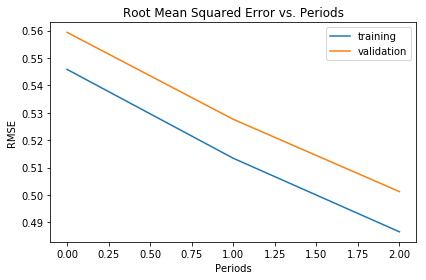

In [92]:
linear_regressor = train_linear_regressor_model(
    learning_rate=0.000001,
    steps=200,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

train a logistic regression model and calculate logloss on validation Set 

In [93]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["Outcome"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["Outcome"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["Outcome"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

Training model...
LogLoss (on training data):
  period 00 : 0.68
  period 01 : 0.68
  period 02 : 0.67
  period 03 : 0.67
  period 04 : 0.67
  period 05 : 0.67
  period 06 : 0.66
  period 07 : 0.66
  period 08 : 0.66
  period 09 : 0.66
Model training finished.


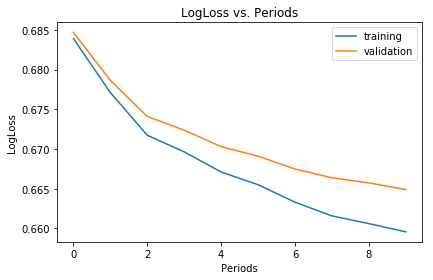

In [94]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=500,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

calculate Accuracy and plot ROC curve for validation Set 

In [95]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["Outcome"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

AUC on the validation set: 0.42
Accuracy on the validation set: 0.64


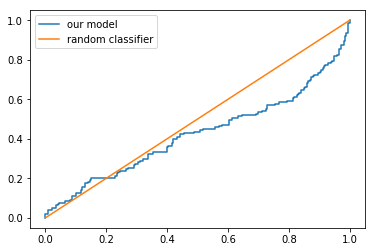

In [96]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

trying to improve AUC tuning the learning settings

Training model...
LogLoss (on training data):
  period 00 : 0.63
  period 01 : 0.62
  period 02 : 0.61
  period 03 : 0.60
  period 04 : 0.60
  period 05 : 0.59
  period 06 : 0.58
  period 07 : 0.58
  period 08 : 0.57
  period 09 : 0.57
Model training finished.
AUC on the validation set: 0.72
Accuracy on the validation set: 0.71


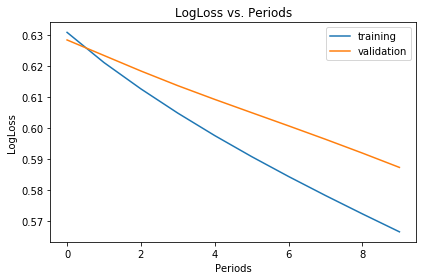

In [97]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000003,
    steps=20000,
    batch_size=500,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

Support Vector Machine 

In [100]:
from sklearn.datasets import fetch_openml
import numpy as np
db = fetch_openml('diabetes', version=1)  # load dataset from https://openml.org/
db.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [101]:
X, y = db["data"],db["target"]

In [102]:
X_train , X_test , y_train , y_test = X[:200], X[200:],y[:200],y[200:]

In [104]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

/home/pradeep/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [108]:
#print confusion matrix and accuracy score
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print(lr_conf_matrix)
print(lr_acc_score*100)

[[329  46]
 [ 85 108]]
76.93661971830986


let's use SVC classifier 

In [105]:
from sklearn.svm import SVC

In [109]:
lin_svc = SVC()
lin_svc.fit(X_train, y_train)
lin_svc_predict=lin_svc.predict(X_test) 

/home/pradeep/.local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [111]:
lin_svc_conf_matrix = confusion_matrix(y_test, lin_svc_predict)
lin_svc_acc_score = accuracy_score(y_test, lin_svc_predict)
print(lin_svc_conf_matrix)
print(lin_svc_acc_score*100)

[[375   0]
 [193   0]]
66.02112676056338
